In [24]:
import pandas as pd
import numpy as np
import libact
from libact.models import SVM
from libact.query_strategies import QUIRE, UncertaintySampling, RandomSampling, ActiveLearningByLearning, HintSVM
import warnings
import matplotlib.pyplot as plt
from libact.models import SklearnAdapter
from sklearn import tree
import seaborn as sbn
import time
from IPython.display import clear_output
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
from Utils import *
from Similarity import *

- Get the Data

In [4]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Notebooks/1_Merging/phone_merged.csv'
phone_result=pd.read_csv(phone_path)
phone_result.head()

,Unnamed: 0,id_webpage,match,page_brand,page_mpn,page_display_size,page_url,page_rear_cam_resolution,page_warc,page_color,page_product_code,page_ram,page_computer_operating_system,page_phone_type,page_processor_type,page_memory,page_front_cam_resolution,page_dimensions,page_display_resolution,page_weight,page_wattage,page_product_type,page_phone_carrier,page_depth,page_width,page_height,page_product_gtin,page_manufacturer,page_modelnum,page_body_material,cat_package_height,cat_computer_operating_system,cat_body_material,cat_display_size,cat_weight,cat_product_code,cat_core_count,cat_processor_type,cat_wattage,cat_modelnum,cat_mpn,cat_color,cat_memory,cat_power_supply,cat_rear_cam_resolution,cat_product_gtin,cat_depth,cat_phone_type,cat_phone_carrier,cat_product_type,cat_width,cat_front_cam_resolution,cat_brand,cat_ram,cat_manufacturer,cat_voltage,cat_display_resolution,cat_dimensions,cat_height,prodcat_product_name,prodcat_id,id
0,0,node5fd6d025f29b89ff319c853d0e33744,0,htc,NaN,5 in,http://www.ebay.com/itm/blocked-htc-one-m9-32g...,20.0mp,ebay.com0.warc.nq.gz,gold on silver,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,t-mobile,0.38 in,2.74 in,5.69 in.,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb875ca-a0e6-11e9-85f7-d0817aaa94da
1,1,nodee9affe60fbe185b64feb5811d2e43159,0,htc,htc6535lvw,5 in,http://www.ebay.com/itm/works-perfect-htc-one-...,20 mp,ebay.com0.warc.nq.gz,gunmetal gray,NaN,NaN,NaN,m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,verizon,0.38 in,2.74 in,5.69 in,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb87822-a0e6-11e9-85f7-d0817aaa94da
2,2,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,0,htc,6735a,5 in,http://www.ebay.com/itm/unlocked-htc-one-m9-32...,20 mp,ebay.com0.warc.nq.gz,gunmetal gray,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,at&t,0.38 in,2.74 in,5.69 in,821793045111,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb8787c-a0e6-11e9-85f7-d0817aaa94da
3,3,node12b450a88f0d6b897758f676414c61,0,htc,opja120,NaN,http://www.ebay.com/itm/refurbished-htc-one-m9...,NaN,ebay.com0.warc.nq.gz,gold,NaN,NaN,NaN,one m9,NaN,32gb,NaN,NaN,NaN,NaN,NaN,NaN,t-mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,iphone 6 64gb,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,3fb878b8-a0e6-11e9-85f7-d0817aaa94da
4,4,node9ace9d5daf49116fed3f11241dff6d,0,htc,ebay_htconem932gbgoldonsilverunlocked,5 in,http://www.ebay.com/itm/nice-factory-unlocked-...,20 mp,ebay.com0.warc.nq.gz,gold on silver,NaN,NaN,android,one m9,NaN,32gb,NaN,NaN,NaN,5.54 oz,2840mah,smartphone,unlocked,0.38 in,2.74 in,5.69 in,NaN,NaN,NaN,NaN,NaN,ios 8,"stainless steel, glass, anodized aluminum",4.7 in,4.5 oz,NaN,NaN,a8,NaN,NaN,mg642ll/a,space gray|silver|gold,64gb,NaN,8 mp,00885909950997,0.3 in,iphone 6,verizon wireless,smartphone,2.6 in,1.2 mp,apple,1gb,NaN,1810 mah,750 x 1334 pixels,138.1 x 67 x 6.9 mm,5.4 in,ipho

In [5]:
phone_result.shape

(21455, 62)

- Look at missing values

In [6]:
no_unq=[len(phone_result[i].unique()) for i in list(phone_result.columns)]

In [7]:
df=pd.DataFrame(phone_result.isna().sum())
df['no_unique_values']=no_unq
df['percent_mis']=df[0]/phone_result.shape[0]

In [8]:
df.sort_values(['percent_mis'])

,0,no_unique_values,percent_mis
Unnamed: 0,0,21455,0.000000
prodcat_product_name,0,48,0.000000
cat_height,0,20,0.000000
cat_display_resolution,0,14,0.000000
cat_ram,0,6,0.000000
cat_brand,0,7,0.000000
cat_width,0,14,0.000000
cat_product_type,0,5,0.000000
cat_phone_type,0,37,0.000000
cat_depth,0,8,0.000000


In [9]:
phone_result.columns  

Index(['Unnamed: 0', 'id_webpage', 'match', 'page_brand', 'page_mpn',
       'page_display_size', 'page_url', 'page_rear_cam_resolution',
       'page_warc', 'page_color', 'page_product_code', 'page_ram',
       'page_computer_operating_system', 'page_phone_type',
       'page_processor_type', 'page_memory', 'page_front_cam_resolution',
       'page_dimensions', 'page_display_resolution', 'page_weight',
       'page_wattage', 'page_product_type', 'page_phone_carrier', 'page_depth',
       'page_width', 'page_height', 'page_product_gtin', 'page_manufacturer',
       'page_modelnum', 'page_body_material', 'cat_package_height',
       'cat_computer_operating_system', 'cat_body_material',
       'cat_display_size', 'cat_weight', 'cat_product_code', 'cat_core_count',
       'cat_processor_type', 'cat_wattage', 'cat_modelnum', 'cat_mpn',
       'cat_color', 'cat_memory', 'cat_power_supply',
       'cat_rear_cam_resolution', 'cat_product_gtin', 'cat_depth',
       'cat_phone_type', 'cat_phone

- Drop full missing columns from the datafarame, and their correpondence in page and category

In [10]:
full_missing_columns=list(df[df['percent_mis']==1].index)
full_missing_columns

['cat_package_height',
 'cat_product_code',
 'cat_wattage',
 'cat_modelnum',
 'cat_power_supply',
 'cat_manufacturer']

In [11]:
only_one_value_cols=list(df[df['no_unique_values']==1].index)
only_one_value_cols

['cat_package_height',
 'cat_product_code',
 'cat_wattage',
 'cat_modelnum',
 'cat_power_supply',
 'cat_manufacturer']

In [12]:
page_col_drop=['page_'+i[4:] for i in full_missing_columns]
cat_col_drop=['cat_'+i[4:] for i in full_missing_columns]
cat_col_drop.extend(page_col_drop)

In [13]:
# check whether every column exists
df_columns=list(phone_result.columns)
new_drop=[]
for i in cat_col_drop:
    if(i in df_columns):
        new_drop.append(i)
new_drop

['cat_package_height',
 'cat_product_code',
 'cat_wattage',
 'cat_modelnum',
 'cat_power_supply',
 'cat_manufacturer',
 'page_product_code',
 'page_wattage',
 'page_modelnum',
 'page_manufacturer']

In [14]:
phone_result=phone_result.drop(new_drop,axis=1)

In [15]:
## not usable:
# Unnamed: 0
# id_webpage
# prodcat_id
# page_url
# page_warc 
# prodcat_product_name

# match

## no matches: 
# cat_voltage
# cat_package_height
# cat_core_count
# cat_power_supply

# page_product_type -> cat_product_type
# page_mpn -> cat_mpn
# page_brand -> cat_brand
# page_phone_type -> cat_product_type
# page_computer_operating_system -> cat_computer_operating_system
# page_memory -> cat_memory
# page_depth -> cat_depth
# page_product_grin -> cat_product_gtin
# page_rear_cam_resolution -> cat_rear_cam_resolution
# page_height -> cat_height
# page_phone_carrier -> cat_phone_carrier
# page_ram -> cat_ram
# page_dimensions -> cat_dimensions
# page_front_cam_resolution -> cat_front_cam_resolution
# page_body_material -> cat_body_material
# page_color -> cat_color
# page_display_size -> cat_display_size
# page_processor_type -> cat_processor_type
# page_weight -> cat_weight
# page_display_resolution -> cat_display_resolution
# page_width -> cat_width

# page_wattage -> cat_wattage (MISSING)
# page_product_code -> cat_product_code (MISSING)
# page_manufacturer -> cat_manufacturer (MISSING)
# page_modelnum -> cat_modelnum. (MISSING)


- Assign 0 for similarity if there is missing in either of the Fields

In [16]:
df2=phone_result[['page_product_type','cat_product_type','page_mpn','cat_mpn','page_brand','cat_brand','page_phone_type','cat_phone_type',
  'page_computer_operating_system','cat_computer_operating_system','page_memory','cat_memory','page_depth','cat_depth',
  'page_product_gtin','cat_product_gtin','page_rear_cam_resolution','cat_rear_cam_resolution',
  'page_height','cat_height','page_phone_carrier','cat_phone_carrier',
  'cat_ram','page_ram','page_dimensions','cat_dimensions','page_front_cam_resolution',
  'cat_front_cam_resolution','page_body_material','cat_body_material','page_color','cat_color',
    'page_display_size','cat_display_size','page_processor_type','cat_processor_type','page_weight','cat_weight','page_display_resolution',
    'cat_display_resolution','page_width','cat_width','match','id_webpage','prodcat_id']]
df2.head()

,page_product_type,cat_product_type,page_mpn,cat_mpn,page_brand,cat_brand,page_phone_type,cat_phone_type,page_computer_operating_system,cat_computer_operating_system,page_memory,cat_memory,page_depth,cat_depth,page_product_gtin,cat_product_gtin,page_rear_cam_resolution,cat_rear_cam_resolution,page_height,cat_height,page_phone_carrier,cat_phone_carrier,cat_ram,page_ram,page_dimensions,cat_dimensions,page_front_cam_resolution,cat_front_cam_resolution,page_body_material,cat_body_material,page_color,cat_color,page_display_size,cat_display_size,page_processor_type,cat_processor_type,page_weight,cat_weight,page_display_resolution,cat_display_resolution,page_width,cat_width,match,id_webpage,prodcat_id
0,smartphone,smartphone,NaN,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20.0mp,8 mp,5.69 in.,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
1,smartphone,smartphone,htc6535lvw,mg642ll/a,htc,apple,m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,verizon,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
2,smartphone,smartphone,6735a,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,821793045111,00885909950997,20 mp,8 mp,5.69 in,5.4 in,at&t,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
3,NaN,smartphone,opja120,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,NaN,0.3 in,NaN,00885909950997,NaN,8 mp,NaN,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold,space gray|silver|gold,NaN,4.7 in,NaN,a8,NaN,4.5 oz,NaN,750 x 1334 pixels,NaN,2.6 in,0,node12b450a88f0d6b897758f676414c61,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80
4,smartphone,smartphone,ebay_htconem932gbgoldonsilverunlocked,mg642ll/a,htc,apple,one m9,iphone 6,android,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,unlocked,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node9ace9d5daf49116fed3f11241dff6d,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80


In [17]:
df2.shape

(21455, 45)

- calculate similarities (jaccard, levenstein, jaro-winkler)

In [18]:
page_columns=get_clean_collist(df2, 'page')
cat_columns=get_clean_collist(df2, 'cat')
jac_columns=get_clean_collist(df2, 'jac')
lev_columns =get_clean_collist(df2, 'lev')
jaro_columns =get_clean_collist(df2, 'jaro')
p_result_nomiss=calculate_similarities_option4(df2,page_columns,cat_columns,jac_columns,lev_columns,jaro_columns)
p_result_nomiss.head()

,page_product_type,cat_product_type,page_mpn,cat_mpn,page_brand,cat_brand,page_phone_type,cat_phone_type,page_computer_operating_system,cat_computer_operating_system,page_memory,cat_memory,page_depth,cat_depth,page_product_gtin,cat_product_gtin,page_rear_cam_resolution,cat_rear_cam_resolution,page_height,cat_height,page_phone_carrier,cat_phone_carrier,cat_ram,page_ram,page_dimensions,cat_dimensions,page_front_cam_resolution,cat_front_cam_resolution,page_body_material,cat_body_material,page_color,cat_color,page_display_size,cat_display_size,page_processor_type,cat_processor_type,page_weight,cat_weight,page_display_resolution,cat_display_resolution,page_width,cat_width,match,id_webpage,prodcat_id,jac_product_type,lev_product_type,jaro_product_type,jac_mpn,lev_mpn,jaro_mpn,jac_brand,lev_brand,jaro_brand,jac_phone_type,lev_phone_type,jaro_phone_type,jac_computer_operating_system,lev_computer_operating_system,jaro_computer_operating_system,jac_memory,lev_memory,jaro_memory,jac_depth,lev_depth,jaro_depth,jac_product_gtin,lev_product_gtin,jaro_product_gtin,jac_rear_cam_resolution,lev_rear_cam_resolution,jaro_rear_cam_resolution,jac_height,lev_height,jaro_height,jac_phone_carrier,lev_phone_carrier,jaro_phone_carrier,jac_ram,lev_ram,jaro_ram,jac_dimensions,lev_dimensions,jaro_dimensions,jac_front_cam_resolution,lev_front_cam_resolution,jaro_front_cam_resolution,jac_body_material,lev_body_material,jaro_body_material,jac_color,lev_color,jaro_color,jac_display_size,lev_display_size,jaro_display_size,jac_processor_type,lev_processor_type,jaro_processor_type,jac_weight,lev_weight,jaro_weight,jac_display_resolution,lev_display_resolution,jaro_display_resolution,jac_width,lev_width,jaro_width
0,smartphone,smartphone,NaN,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20.0mp,8 mp,5.69 in.,5.4 in,t-mobile,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gold on silver,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,node5fd6d025f29b89ff319c853d0e33744,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,-1.0,-1.000000,-1.000000,0.0,0.0,0.0,0.142857,0.375,0.722222,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.0,0.833333,0.955556,-1.0,-1.000000,-1.000000,0.0,0.4,0.633333,0.0,0.666667,0.84,0.000000,0.2500,0.500000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.285714,0.35,0.490476,0.0,0.6,0.783333,-1.0,-1.0,-1.0,0.0,0.666667,0.877778,-1.0,-1.0,-1.0,0.0,0.666667,0.84
1,smartphone,smartphone,htc6535lvw,mg642ll/a,htc,apple,m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,NaN,00885909950997,20 mp,8 mp,5.69 in,5.4 in,verizon,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodee9affe60fbe185b64feb5811d2e43159,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,0.0,0.200000,0.483333,0.0,0.0,0.0,0.000000,0.000,0.000000,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.0,0.833333,0.955556,-1.0,-1.000000,-1.000000,0.0,0.6,0.783333,0.0,0.666667,0.84,0.384615,0.4375,0.894531,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.080000,0.20,0.565954,0.0,0.6,0.783333,-1.0,-1.0,-1.0,0.0,0.666667,0.877778,-1.0,-1.0,-1.0,0.0,0.666667,0.84
2,smartphone,smartphone,6735a,mg642ll/a,htc,apple,one m9,iphone 6,NaN,ios 8,32gb,64gb,0.38 in,0.3 in,821793045111,00885909950997,20 mp,8 mp,5.69 in,5.4 in,at&t,verizon wireless,1gb,NaN,NaN,138.1 x 67 x 6.9 mm,NaN,1.2 mp,NaN,"stainless steel, glass, anodized aluminum",gunmetal gray,space gray|silver|gold,5 in,4.7 in,NaN,a8,5.54 oz,4.5 oz,NaN,750 x 1334 pixels,2.74 in,2.6 in,0,nodeb1d0ceb9797fd339c5f7c04aa76a7af1,a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80,1.0,1.0,1.0,0.0,0.250000,0.550000,0.0,0.0,0.0,0.142857,0.375,0.722222,-1.0,-1.0,-1.0,0.0,0.5,0.666667,0.0,0.833333,0.955556,0.0,0.142857,0.373016,0.0,0.6,0.783333,0.0,0.666667,0.84,0.0000

- After calculating similarities, some columns might get the same value. So we are dropping them

In [19]:
jac_columns_el=eliminate_columns(p_result_nomiss,jac_columns)
lev_columns_el=eliminate_columns(p_result_nomiss,lev_columns)
jaro_columns_el=eliminate_columns(p_result_nomiss,jaro_columns)

# 1. Clustering

## 1.1. USING ONLY JACCARD

In [37]:
cols= jac_columns_el.copy()
df_clust=df2[cols]
cols.append('match')

In [32]:
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)


In [38]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
labels_kmean=kmeans.labels_
cols.remove('match')
df_Xtrain=pd.DataFrame(X_train,columns=cols)
df_Xtrain['cluster']=labels_kmean
df_Xtrain['match']=y_train
df_Xtrain.head()

,jac_product_type,jac_mpn,jac_brand,jac_phone_type,jac_computer_operating_system,jac_memory,jac_depth,jac_product_gtin,jac_rear_cam_resolution,jac_height,jac_phone_carrier,jac_ram,jac_dimensions,jac_front_cam_resolution,jac_body_material,jac_color,jac_display_size,jac_processor_type,jac_weight,jac_display_resolution,jac_width,cluster,match
0,-1.0,-1.0,1.0,0.833333,0.125,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8,0
1,0.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0
2,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0
3,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,0
4,-1.0,-1.0,0.0,0.000000,-1.000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,2,0


In [39]:
for i in df_Xtrain['cluster'].unique():
    clust_1=df_Xtrain[df_Xtrain['cluster']==i]
    print('cluster:',i)
    print('shape:',clust_1.shape)
    print('number of 1s:',clust_1['match'].sum())

cluster: 8
shape: (1263, 23)
number of 1s: 8
cluster: 1
shape: (3458, 23)
number of 1s: 0
cluster: 2
shape: (2037, 23)
number of 1s: 18
cluster: 3
shape: (1231, 23)
number of 1s: 21
cluster: 9
shape: (718, 23)
number of 1s: 16
cluster: 6
shape: (1844, 23)
number of 1s: 24
cluster: 7
shape: (852, 23)
number of 1s: 9
cluster: 0
shape: (1027, 23)
number of 1s: 4
cluster: 4
shape: (1160, 23)
number of 1s: 30
cluster: 5
shape: (784, 23)
number of 1s: 18


In [40]:
from sklearn import metrics
metrics.silhouette_score(df_Xtrain[cols], labels_kmean, metric='euclidean')

0.20082859509424092

## 1.2. USING ONLY LEVENSTEIN

In [49]:
cols= lev_columns_el.copy()
df_clust=df2[cols]
cols.append('match')

In [50]:
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)


In [51]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
labels_kmean=kmeans.labels_
cols.remove('match')
df_Xtrain=pd.DataFrame(X_train,columns=cols)
df_Xtrain['cluster']=labels_kmean
df_Xtrain['match']=y_train
df_Xtrain.head()

,lev_product_type,lev_mpn,lev_brand,lev_phone_type,lev_computer_operating_system,lev_memory,lev_depth,lev_product_gtin,lev_rear_cam_resolution,lev_height,lev_phone_carrier,lev_ram,lev_dimensions,lev_front_cam_resolution,lev_body_material,lev_color,lev_display_size,lev_processor_type,lev_weight,lev_display_resolution,lev_width,cluster,match
0,-1.0,-1.0,1.000000,0.888889,0.363636,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,5,0
1,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0000,-1.0,-1.0,-1.0,-1.0,-1.0,7,0
2,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.2500,-1.0,-1.0,-1.0,-1.0,-1.0,7,0
3,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0625,-1.0,-1.0,-1.0,-1.0,-1.0,7,0
4,-1.0,-1.0,0.142857,0.071429,-1.000000,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0000,0.6,-1.0,-1.0,-1.0,-1.0,2,0


In [52]:
for i in df_Xtrain['cluster'].unique():
    clust_1=df_Xtrain[df_Xtrain['cluster']==i]
    print('cluster:',i)
    print('shape:',clust_1.shape)
    print('number of 1s:',clust_1['match'].sum())

cluster: 5
shape: (2782, 23)
number of 1s: 26
cluster: 7
shape: (2455, 23)
number of 1s: 0
cluster: 2
shape: (1453, 23)
number of 1s: 24
cluster: 8
shape: (2177, 23)
number of 1s: 41
cluster: 0
shape: (1178, 23)
number of 1s: 20
cluster: 6
shape: (418, 23)
number of 1s: 5
cluster: 9
shape: (895, 23)
number of 1s: 3
cluster: 4
shape: (952, 23)
number of 1s: 8
cluster: 1
shape: (1100, 23)
number of 1s: 0
cluster: 3
shape: (964, 23)
number of 1s: 21


In [53]:
from sklearn import metrics
metrics.silhouette_score(df_Xtrain[cols], labels_kmean, metric='euclidean')

0.21082386520886295

## 1.3. USING ONLY JARO

In [54]:
cols= jaro_columns_el.copy()
df_clust=df2[cols]
cols.append('match')

In [55]:
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)


In [56]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
labels_kmean=kmeans.labels_
cols.remove('match')
df_Xtrain=pd.DataFrame(X_train,columns=cols)
df_Xtrain['cluster']=labels_kmean
df_Xtrain['match']=y_train
df_Xtrain.head()

,jaro_product_type,jaro_mpn,jaro_brand,jaro_phone_type,jaro_computer_operating_system,jaro_memory,jaro_depth,jaro_product_gtin,jaro_rear_cam_resolution,jaro_height,jaro_phone_carrier,jaro_ram,jaro_dimensions,jaro_front_cam_resolution,jaro_body_material,jaro_color,jaro_display_size,jaro_processor_type,jaro_weight,jaro_display_resolution,jaro_width,cluster,match
0,-1.00000,-1.0,1.000000,0.992593,0.82259,0.666667,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,6,0
1,0.41453,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,9,0
2,-1.00000,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.600000,-1.000000,-1.0,-1.0,-1.0,-1.0,1,0
3,-1.00000,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.402778,-1.000000,-1.0,-1.0,-1.0,-1.0,1,0
4,-1.00000,-1.0,0.447619,0.404762,-1.00000,0.722222,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.866667,-1.0,-1.0,-1.0,-1.0,3,0


In [57]:
for i in df_Xtrain['cluster'].unique():
    clust_1=df_Xtrain[df_Xtrain['cluster']==i]
    print('cluster:',i)
    print('shape:',clust_1.shape)
    print('number of 1s:',clust_1['match'].sum())

cluster: 6
shape: (1611, 23)
number of 1s: 12
cluster: 9
shape: (1161, 23)
number of 1s: 0
cluster: 1
shape: (1995, 23)
number of 1s: 0
cluster: 3
shape: (2275, 23)
number of 1s: 31
cluster: 7
shape: (1217, 23)
number of 1s: 17
cluster: 2
shape: (1547, 23)
number of 1s: 25
cluster: 5
shape: (1774, 23)
number of 1s: 18
cluster: 8
shape: (1031, 23)
number of 1s: 8
cluster: 0
shape: (934, 23)
number of 1s: 23
cluster: 4
shape: (829, 23)
number of 1s: 14


In [58]:
from sklearn import metrics
metrics.silhouette_score(df_Xtrain[cols], labels_kmean, metric='euclidean')

0.2065405608341473

## 1.4. USING ALL VARIABLES

In [60]:
cols= jac_columns_el.copy()
cols.extend(lev_columns_el)
cols.extend(jaro_columns_el)
cols.append('match')
df_clust=df2[cols]

In [61]:
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)


In [62]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
labels_kmean=kmeans.labels_
cols.remove('match')
df_Xtrain=pd.DataFrame(X_train,columns=cols)
df_Xtrain['cluster']=labels_kmean
df_Xtrain['match']=y_train
df_Xtrain.head()

,jac_product_type,jac_mpn,jac_brand,jac_phone_type,jac_computer_operating_system,jac_memory,jac_depth,jac_product_gtin,jac_rear_cam_resolution,jac_height,jac_phone_carrier,jac_ram,jac_dimensions,jac_front_cam_resolution,jac_body_material,jac_color,jac_display_size,jac_processor_type,jac_weight,jac_display_resolution,jac_width,lev_product_type,lev_mpn,lev_brand,lev_phone_type,lev_computer_operating_system,lev_memory,lev_depth,lev_product_gtin,lev_rear_cam_resolution,lev_height,lev_phone_carrier,lev_ram,lev_dimensions,lev_front_cam_resolution,lev_body_material,lev_color,lev_display_size,lev_processor_type,lev_weight,lev_display_resolution,lev_width,jaro_product_type,jaro_mpn,jaro_brand,jaro_phone_type,jaro_computer_operating_system,jaro_memory,jaro_depth,jaro_product_gtin,jaro_rear_cam_resolution,jaro_height,jaro_phone_carrier,jaro_ram,jaro_dimensions,jaro_front_cam_resolution,jaro_body_material,jaro_color,jaro_display_size,jaro_processor_type,jaro_weight,jaro_display_resolution,jaro_width,cluster,match
0,-1.0,-1.0,1.0,0.833333,0.125,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.000000,0.888889,0.363636,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,1.000000,0.992593,0.82259,0.666667,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,6,0
1,0.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0000,-1.0,-1.0,-1.0,-1.0,-1.0,0.41453,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,2,0
2,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.2500,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.600000,-1.000000,-1.0,-1.0,-1.0,-1.0,2,0
3,-1.0,-1.0,-1.0,-1.000000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0625,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.402778,-1.000000,-1.0,-1.0,-1.0,-1.0,2,0
4,-1.0,-1.0,0.0,0.000000,-1.000,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.142857,0.071429,-1.000000,0.5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0000,0.6,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,0.447619,0.404762,-1.00000,0.722222,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.866667,-1.0,-1.0,-1.0,-1.0,0,0


In [63]:
for i in df_Xtrain['cluster'].unique():
    clust_1=df_Xtrain[df_Xtrain['cluster']==i]
    print('cluster:',i)
    print('shape:',clust_1.shape)
    print('number of 1s:',clust_1['match'].sum())

cluster: 6
shape: (1300, 65)
number of 1s: 12
cluster: 2
shape: (2057, 65)
number of 1s: 0
cluster: 0
shape: (2263, 65)
number of 1s: 31
cluster: 9
shape: (1476, 65)
number of 1s: 0
cluster: 3
shape: (1179, 65)
number of 1s: 18
cluster: 8
shape: (1549, 65)
number of 1s: 25
cluster: 7
shape: (1662, 65)
number of 1s: 18
cluster: 1
shape: (1012, 65)
number of 1s: 4
cluster: 5
shape: (1034, 65)
number of 1s: 22
cluster: 4
shape: (842, 65)
number of 1s: 18


In [64]:
from sklearn import metrics
metrics.silhouette_score(df_Xtrain[cols], labels_kmean, metric='euclidean')

0.1985440528389869

# 2. Seed Product Iteration

In [35]:
def get_seed_random_speed(y_train, seed=10):
    """
    Get the seeds randomly. In order to make sure that the randomly selected seeds, have at least a match, draw random samples
    indefinetly until you find a sample that have at least a match.
    """
    df2=pd.DataFrame(y_train)
    i = 0
    count = 0
    while (i==0): 
        samp=df2.sample(seed)
        if 1 in list(samp[0]):
            break
        count=count+1
    return list(samp.index), count

In [36]:
from sklearn.cluster import KMeans
import random

def get_seed_cluster_speed(y_train, df2, seed=10):
    """
    Get the seeds randomly. In order to make sure that the randomly selected seeds, have at least a match, draw random samples
    indefinetly until you find a sample that have at least a match.
    """
    
    kmeans = KMeans(n_clusters=seed, random_state=0).fit(df2)
    labels_kmean=kmeans.labels_
    cluster = labels_kmean

    i = 0
    count = 0
    
    while (i==0):
        samp_index =[]
        for k in range(0,seed):
            samp_index.append(random.sample(count_in_list(cluster, k),1)[0])
        
        matchs=[y_train[j] for j in samp_index]
        
        if 1 in list(matchs):
            break
        count=count+1
    
    return list(samp_index), count

In [37]:
def count_in_list(ls, ct):
    sel=[]
    i=0
    while i<len(ls): 
        if (ls[i]==ct):
            sel.append(i)
        i=i+1
    
    return sel

- Speed

In [23]:
cols= jac_columns_el.copy()
cols.extend(lev_columns_el)
cols.extend(jaro_columns_el)

In [39]:
clust_seed, random_seed =[],[]
for i in range(0,500):
    clear_output(wait=True)
    clust_seed.append(get_seed_cluster_speed(list(df2['match']), df2[cols], jac_columns_el, lev_columns_el, jaro_columns_el, seed=10)[1])
    random_seed.append(get_seed_random_speed(list(df2['match']), seed=10)[1])
    print(i)

499


In [42]:
np.mean(clust_seed)

8.95

In [43]:
np.mean(random_seed)

9.606

> On average with clustering, with 8.95 iterations we are able to reach the conclusion, considering the seed size of 10, this means that for clustering we need to label 89 instances on average to overcome the miss classification effect.

- Convergence (using all variables)

In [49]:
p_result_nomiss_jac=df2[cols]
X_train, X_test, y_train, y_test = train_test_split(p_result_nomiss_jac.drop('match',axis=1).values,p_result_nomiss_jac['match'].values,test_size=0.33,random_state=42)

# we start with 10 labeled instances, make the other instances 'None'
seed=10
samp=get_seed_random_speed(y_train,10)[0]
samp_clust=get_seed_cluster_speed(y_train, X_train, jac_columns_el, lev_columns_el, jaro_columns_el, seed=10)[0]

In [51]:
from sklearn.linear_model import LogisticRegression as ls 
f1_score_log, tn_log, fp_log, fn_log, tp_log = get_base_model_result(y_test, y_train, X_test, X_train, ls())
print(f1_score_log)
print(tn_log)
print(fp_log)
print(fn_log)
print(tp_log)

0.6722689075630252
7002
9
30
40


In [52]:
run_=10
missing_option='opt4'
features='allvar'
q_type='uncertainity'

(with random seeding)

In [59]:
alg='log'
start_time = time.time()
trn_ds_random = Dataset(X_train, prepare_ytrain_foract(y_train, samp))
tst_ds_random = Dataset(X_test, y_test)

qs = UncertaintySampling(trn_ds_random, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)+'_seedtesting_random'
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log_r, iter_u_log_r, f1score_u_log_r, tn_u_log_r, fp_u_log_r,fn_u_log_r, tp_u_log_r, k_u_log_r, trn_dss_u_log_r, label_holder_u_log_r, asked_id_u_log_r = run_faster(trn_ds_random, tst_ds_random, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.6722689075630252
Current progress: 100.0 %
3149.4546732902527


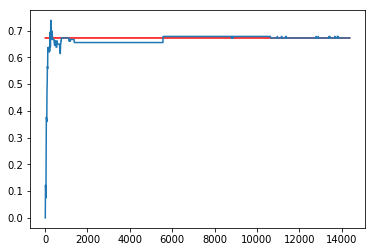

In [60]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log_r)

(with cluster seeding)

In [57]:
alg='log'
start_time = time.time()
trn_ds_clust = Dataset(X_train, prepare_ytrain_foract(y_train, samp_clust))
tst_ds_clust = Dataset(X_test, y_test)

qs = UncertaintySampling(trn_ds_clust, method='lc', model=LogisticRegression())
model = LogisticRegression()
name='Faster_Phone_'+missing_option+'_'+features+'_'+q_type+'_'+alg+'_'+str(run_)+'_seedtesting_cluster'
#r,iter_,f1,askid,lbls=run_20(trn_ds, tst_ds, y_train, model, qs, quota, X_test, y_test,name)
q_u_log, iter_u_log, f1score_u_log, tn_u_log, fp_u_log,fn_u_log, tp_u_log, k_u_log, trn_dss_u_log, label_holder_u_log, asked_id_u_log = run_faster(trn_ds_clust, tst_ds_clust, y_train, model, qs, X_test, y_test,name,True,run_)
end_time = time.time()
print(end_time-start_time)

14374
14374
train dataset labeled: 14374
train dataset sum: 148
Current f1 score: 0.6722689075630252
Current progress: 100.0 %
3047.550227880478


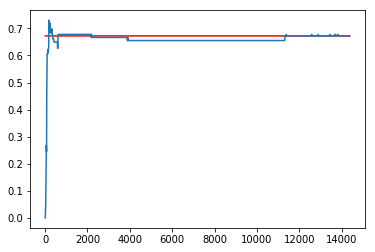

In [58]:
plt.plot(q_u_log, [f1_score_log] * (len(q_u_log)), '-r')
plt.plot(q_u_log, f1score_u_log)

(comparison)

In [71]:
df_random = pd.DataFrame({'iteration':q_u_log,'f1-score':f1score_u_log_r})
df_random_30=df_random.head(100)
df_random_30.head()

,iteration,f1-score
0,10,0.000000
1,20,0.122449
2,30,0.106383
3,40,0.075000
4,50,0.219780


In [72]:
df_clust = pd.DataFrame({'iteration':q_u_log,'f1-score':f1score_u_log})
df_clust_30=df_clust.head(100)
df_clust_30.head()

,iteration,f1-score
0,10,0.000000
1,20,0.027397
2,30,0.051282
3,40,0.139535
4,50,0.193548


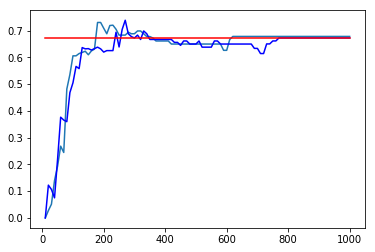

In [78]:
plt.plot(df_clust_30['iteration'],df_clust_30['f1-score'])
plt.plot(df_random_30['iteration'],df_random_30['f1-score'],'-b')
plt.plot(df_random_30['iteration'],  [f1_score_log]* (100), '-r')